## Import Dependencies

In [63]:
import os
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import accuracy_score

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b7

from tqdm.auto import tqdm

In [45]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"

## View the Dataset

In [46]:
# Check label balances 
for folder in os.listdir("data3a\\training"):
    folder_path = os.path.join("data3a\\training", folder)
    print(f"There are {len(os.listdir(folder_path))} images in {folder}")

There are 452 images in minor
There are 463 images in moderate
There are 468 images in severe


## Creating the Dataset

In [47]:
# Create transform pipeline

augment_pipeline = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

val_pipeline = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [48]:
# Create Dataset
train_dataset = ImageFolder("data3a\\training", transform=augment_pipeline)
val_dataset = ImageFolder("data3a\\validation", transform=val_pipeline)

In [49]:
# Create Dataloader
BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [50]:
# Check number of batches
len(train_dataloader), len(val_dataloader)

(87, 16)

## Initial Data Visualization

In [51]:
labels_dict = {
    0 : "minor",
    1 : "moderate",
    2 : "severe"
}

In [52]:
# View a few images from the dataloader
data_iter = iter(train_dataloader)
example_batch = next(data_iter)

In [53]:
example_batch

[tensor([[[[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           ...,
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431]],
 
          [[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           ...,
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431]],
 
          [[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
           [0.0431, 0.04

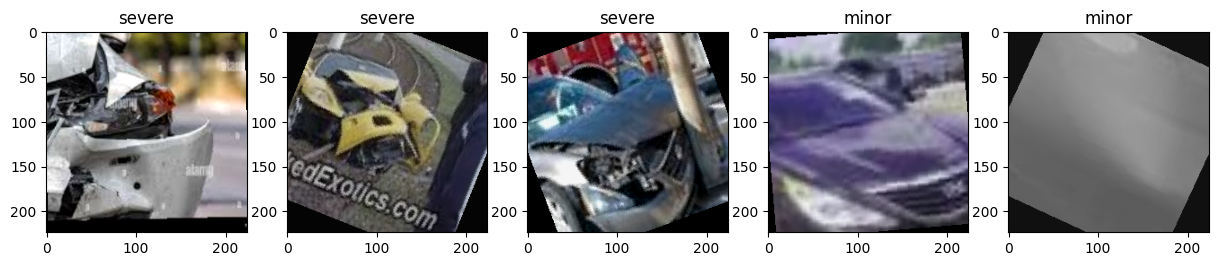

In [54]:
# Plot 5 images from the training dataloader
fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (15,10))
random_indices = np.random.randint(BATCH_SIZE, size = 5)
for i, batch_idx in enumerate(random_indices):
    image = torch.permute(example_batch[0][batch_idx],[1,2,0])
    axes[i].imshow(image)
    label = example_batch[1][batch_idx]
    axes[i].set_title(labels_dict[label.item()])

## Data Modeling

### Initialize EfficientNetB7

In [72]:
# Initialize Pretrained Model
model = efficientnet_b7(weights="EfficientNet_B7_Weights.DEFAULT")

In [73]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [74]:
model.classifier[1] = nn.Linear(in_features=2560, out_features=3, bias = True)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

### Optimizer and Loss Function

In [75]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode = "min", factor = 0.2, patience = 3, verbose = True)
scaler = torch.cuda.amp.GradScaler()

In [76]:
def check_accuracy(y_pred_logits, y_true):
    predictions = torch.argmax(y_pred_logits, dim = 1)
    accuracy = accuracy_score(y_true.cpu().numpy(), predictions.cpu().numpy())
    
    return accuracy

In [77]:
# Basic training function
# for _ in range(4):
#     X, y = example_batch
#     y_pred = model(X)
#     loss = criterion(y_pred, y)
#     print(loss.item())
#     accuracy = check_accuracy(y_pred, y)
#     print("Accuracy:",accuracy)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

In [78]:
# Create model results directory
directory_path = "results"

if not os.path.exists(directory_path):
    os.makedirs("results")
    print(f"Directory '{directory_path}' created.")
else:
    print(f"Directory '{directory_path}' already exists.")

Directory 'results' already exists.


In [79]:
def train_step(model, train_loader, val_loader, optimizer, scheduler, scaler, criterion, num_epochs, total_patience = 7, model_weights = None, device = device):
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    
    best_val_loss = float("inf")
    patience = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        loop = tqdm(enumerate(train_loader), total = len(train_loader), leave = False)
        for batch, (X, y) in loop:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            with torch.cuda.amp.autocast(enabled=False):
                # Get predictions
                y_pred = model(X)
            
                # Calulcate loss
                train_loss = criterion(y_pred, y)
                total_train_loss += train_loss.item()
            
            # Get accuracy
            batch_accuracy = check_accuracy(y_pred, y)
            total_train_acc += batch_accuracy
            
            # Zero optimizer
            optimizer.zero_grad()
            
            # Backpropagation
            scaler.scale(train_loss).backward()
            
            # Gradient Descent
            scaler.step(optimizer)
            scaler.update()
            
            # Update Progress Bar
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss = train_loss.item(), acc = batch_accuracy)
                 
        # Calculate total loss value (average of all batches)   
        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss)
        
        # calculate total accuracy
        average_train_accuracy = total_train_acc / len(train_loader)
        train_accuracy.append(average_train_accuracy)
        
        # Check Validation
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.inference_mode():
            val_loop = tqdm(enumerate(val_loader), total = len(val_dataloader), leave = False)
            for batch, (X,y) in val_loop:
                X, y = X.to(device), y.to(device)
                
                with torch.cuda.amp.autocast(enabled=False):
                    y_pred = model(X)
                    
                    val_loss = criterion(y_pred, y)
                    total_val_loss += val_loss.item()
                
                batch_accuracy = check_accuracy(y_pred, y)
                total_val_acc += batch_accuracy
                
                val_loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
                val_loop.set_postfix(loss = val_loss.item(), acc = batch_accuracy)
                  
        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)
        
        average_val_accuracy = total_val_acc / len(val_loader)
        val_accuracy.append(average_val_accuracy)
        
        
        # Early Stopping and Model Checkpoint
        if average_val_loss < best_val_loss:
            print(f"Validation Loss Improved From: {best_val_loss} to {average_val_loss}")
            best_val_loss = average_val_loss
            
            # Save entire model
            torch.save(model.state_dict(), "results/vehicle_classification_weights.pth")
            print("Saved Weights to vehicle_classification_weights.pth")
            
            patience = 0
        else:
            print("Validation Loss Did not Improve")
            patience += 1
            
            if patience == total_patience:
                print("End Training: Early Stopping")
                print(f"Epoch: {epoch+1} | Train Loss: {average_train_loss:.4f} | Validation Loss: {average_val_loss:.4f} | Train Accuracy: {average_train_accuracy:.4f} | Validation Accuracy: {average_val_accuracy:.4f}")
                break
        scheduler.step(average_val_loss)       
        print(f"Epoch: {epoch+1} | Train Loss: {average_train_loss:.4f} | Validation Loss: {average_val_loss:.4f} | Train Accuracy: {average_train_accuracy:.4f} | Validation Accuracy: {average_val_accuracy:.4f}")
    return {"Train Accuracy" : train_accuracy, "Validation Accuracy" : val_accuracy, "Train Loss" : train_losses, "Validation Loss" : val_losses}

In [80]:
# Deterministic Behavior
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Training
NUM_EPOCHS = 30
history = train_step(model, train_dataloader, val_dataloader, optimizer, scheduler, scaler, criterion, NUM_EPOCHS)

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Improved From: inf to 0.9686923027038574
Saved Weights to vehicle_classification_weights.pth
Epoch: 1 | Train Loss: 1.0597 | Validation Loss: 0.9687 | Train Accuracy: 0.4326 | Validation Accuracy: 0.6016


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Improved From: 0.9686923027038574 to 0.7192521467804909
Saved Weights to vehicle_classification_weights.pth
Epoch: 2 | Train Loss: 0.9192 | Validation Loss: 0.7193 | Train Accuracy: 0.5525 | Validation Accuracy: 0.7109


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Improved From: 0.7192521467804909 to 0.652054263278842
Saved Weights to vehicle_classification_weights.pth
Epoch: 3 | Train Loss: 0.8479 | Validation Loss: 0.6521 | Train Accuracy: 0.6020 | Validation Accuracy: 0.7422


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Improved From: 0.652054263278842 to 0.6360781714320183
Saved Weights to vehicle_classification_weights.pth
Epoch: 4 | Train Loss: 0.8120 | Validation Loss: 0.6361 | Train Accuracy: 0.6212 | Validation Accuracy: 0.7109


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Improved From: 0.6360781714320183 to 0.6072692461311817
Saved Weights to vehicle_classification_weights.pth
Epoch: 5 | Train Loss: 0.7550 | Validation Loss: 0.6073 | Train Accuracy: 0.6500 | Validation Accuracy: 0.7422


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Improved From: 0.6072692461311817 to 0.6044025849550962
Saved Weights to vehicle_classification_weights.pth
Epoch: 6 | Train Loss: 0.7480 | Validation Loss: 0.6044 | Train Accuracy: 0.6622 | Validation Accuracy: 0.7266


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Improved From: 0.6044025849550962 to 0.5973664671182632
Saved Weights to vehicle_classification_weights.pth
Epoch: 7 | Train Loss: 0.7052 | Validation Loss: 0.5974 | Train Accuracy: 0.6833 | Validation Accuracy: 0.7148


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 8 | Train Loss: 0.6962 | Validation Loss: 0.6147 | Train Accuracy: 0.6993 | Validation Accuracy: 0.7109


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 9 | Train Loss: 0.6552 | Validation Loss: 0.6173 | Train Accuracy: 0.7072 | Validation Accuracy: 0.7070


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 10 | Train Loss: 0.6168 | Validation Loss: 0.6113 | Train Accuracy: 0.7447 | Validation Accuracy: 0.7031


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Improved From: 0.5973664671182632 to 0.5971256662160158
Saved Weights to vehicle_classification_weights.pth
Epoch: 11 | Train Loss: 0.6025 | Validation Loss: 0.5971 | Train Accuracy: 0.7350 | Validation Accuracy: 0.6836


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 12 | Train Loss: 0.5806 | Validation Loss: 0.7153 | Train Accuracy: 0.7467 | Validation Accuracy: 0.6836


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 13 | Train Loss: 0.5127 | Validation Loss: 0.7066 | Train Accuracy: 0.7877 | Validation Accuracy: 0.7031


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 14 | Train Loss: 0.4969 | Validation Loss: 0.6575 | Train Accuracy: 0.7921 | Validation Accuracy: 0.6875


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch 00015: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 15 | Train Loss: 0.4857 | Validation Loss: 0.6572 | Train Accuracy: 0.7872 | Validation Accuracy: 0.6914


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 16 | Train Loss: 0.4350 | Validation Loss: 0.6597 | Train Accuracy: 0.8300 | Validation Accuracy: 0.6992


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 17 | Train Loss: 0.4388 | Validation Loss: 0.6678 | Train Accuracy: 0.8190 | Validation Accuracy: 0.6953


  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Validation Loss Did not Improve
End Training: Early Stopping
Epoch: 18 | Train Loss: 0.4364 | Validation Loss: 0.6767 | Train Accuracy: 0.8313 | Validation Accuracy: 0.6797
